## Parameter estimation for a 2D system


Along the same lines as the previous example, we take a 2-dimensional linear operator corresponding to a 2-dimensional system with a single parameter. As previously explained, we setup our problem as below:


\begin{align*}
\mathcal{L}_\bar{x}^\phi u(\bar{x}) &= f(\bar{x}), \quad \bar{x} := (x_1, x_2)^T \\
\mathbb{X} := [0,1]^2; \mathbb{K} &\subset \mathbb{R}; u,f \in C(\mathbb{X}, \mathbb{K}) \\
\mathcal{L}_\bar{x}^\phi &: C(\mathbb{X}, \mathbb{K}) \rightarrow C(\mathbb{X}, \mathbb{K})\\
\mathcal{L}_x^\phi &:= \phi \cdot + \frac{d}{dx_1}\cdot + \frac{d^2}{dx_2^2}\cdot
\end{align*}

It is easy to verify that $\mathcal{L}_\bar{x}^\phi$ is linear and continuous. A suitable solution for the operator is

\begin{align*}
u(\bar{x}) &= x_1 x_2 - x_2^2 \\
f(\bar{x}) &= \phi x_1 x_2 - \phi x_2^2 + x_2 - 2
\end{align*}

Now, we put the Gaussian priors as earlier, except that they are now defined on a 2-dimensional space. The exact form of the prior and calculations are discussed in a later section.

\begin{align*}
u(\bar{x}) &\sim \mathcal{GP}(0, k_{uu}(\bar{x},\bar{x}',\theta)) \\
f(\bar{x}) &\sim \mathcal{GP}(0, k_{ff}(\bar{x},\bar{x}',\theta,\phi)) \\
y_u &= u(X) + \epsilon_u; \epsilon_u \sim \mathcal{N}(0, \sigma_u^2I) \\
y_f &= f(X) + \epsilon_f; \epsilon_f \sim \mathcal{N}(0, \sigma_f^2I)
\end{align*}


The parameter estimation problem for the linear operator described above is to estimate $\phi$, given $\{x, y_u, y_f\}$. Notice that we evaluate $u, f$ on the same set of points because it makes sense from a physics point of view.


#### Simulate data


We use $\phi = 2$ and try to estimate it.


In [1]:
import numpy as np
import sympy as sp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time

In [2]:
def get_simulated_data(n, phi):
    x = np.random.rand(n,2)
    y_u = np.multiply(x[:,0], x[:,1]) - x[:,1]**2
    y_f = phi*y_u + x[:,1] - 2
    return (x, y_u, y_f)

#### Evaluate kernels



The implementation of the kernels is straightforward as done earlier. Consequently, the corresponding code has been omitted from the report.

\begin{align*}
k_{uu}(\bar{x}_i, \bar{x}_j; \theta) &=  \theta exp(-\frac{(x_{i,1}-x_{j,1})^2}{2l_1} -\frac{(x_{i,2}-x_{j,2})^2}{2l_2})\\
k_{ff}(\bar{x}_i,\bar{x}_j;\theta,\phi) &= \mathcal{L}_{\bar{x}_i}^\phi \mathcal{L}_{\bar{x}_j}^\phi k_{uu}(\bar{x}_i, \bar{x}_j; \theta) \\
&= \mathcal{L}_{\bar{x}_i}^\phi \left( \phi k_{uu} + \frac{\partial}{\partial x_{j,1}}k_{uu} + \frac{\partial^2}{\partial^2 x_{j,2}}k_{uu}\right) \\
&= \phi^2 k_{uu} + \phi \frac{\partial}{\partial x_{j,1}}k_{uu} + \phi \frac{\partial}{\partial x_{i,1}}k_{uu} \\
& \quad + \phi \frac{\partial^2}{\partial^2 x_{j,2}}k_{uu} + \frac{\partial}{\partial x_{i,1}}\frac{\partial}{\partial x_{j,1}}k_{uu} + \phi \frac{\partial^2}{\partial^2 x_{i,2}}k_{uu} \\
& \quad + \frac{\partial}{\partial x_{i,1}}\frac{\partial^2}{\partial^2 x_{j,2}}k_{uu} + \frac{\partial^2}{\partial^2 x_{i,2}}\frac{\partial}{\partial x_{j,1}}k_{uu} + \frac{\partial^2}{\partial^2 x_{i,2}}\frac{\partial^2}{\partial^2 x_{j,2}}k_{uu}\\
k_{fu}(\bar{x}_i,\bar{x}_j;\theta,\phi) &= \mathcal{L}_{\bar{x}_i}^\phi k_{uu}(\bar{x}_i, \bar{x}_j; \theta) \\
&= \phi k_{uu} + \frac{\partial}{\partial x_{i,1}}k_{uu} + \frac{\partial^2}{\partial x_{i,2}^2}k_{uu}
\end{align*}


In [3]:
xi1, xj1, xi2, xj2, theta, l1, l2, phi = sp.symbols('xi1 xj1 xi2 xj2 theta l1 l2 phi')
# kuu_sym = theta*sp.exp(-((xi1 - xj1)**2)/(2*l1) - ((xi2 - xj2)**2)/(2*l2))
kuu_sym = theta*sp.exp(-l1*((xi1 - xj1)**2) - l2*((xi2 - xj2)**2))
kuu_fn = sp.lambdify((xi1, xj1, xi2, xj2, theta, l1, l2), kuu_sym, "numpy")
def kuu(x, theta, l1, l2):
    k = np.zeros((x.shape[0], x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            k[i,j] = kuu_fn(x[i,0], x[j,0], x[i,1], x[j,1], theta, l1, l2)
    return k

In [4]:
kff_sym = phi**2*kuu_sym \
            + phi*sp.diff(kuu_sym, xj1) \
            + phi*sp.diff(kuu_sym, xj2, xj2) \
            + phi*sp.diff(kuu_sym, xi1) \
            + sp.diff(kuu_sym, xj1, xi1) \
            + sp.diff(kuu_sym, xj2, xj2, xi1) \
            + phi*sp.diff(kuu_sym, xi2, xi2) \
            + sp.diff(kuu_sym, xj1, xi2, xi2) \
            + sp.diff(kuu_sym, xj2, xj2, xi2, xi2)
kff_fn = sp.lambdify((xi1, xj1, xi2, xj2, theta, l1, l2, phi), kff_sym, "numpy")
def kff(x, theta, l1, l2, phi):
    k = np.zeros((x.shape[0], x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            k[i,j] = kff_fn(x[i,0], x[j,0], x[i,1], x[j,1], theta, l1, l2, phi)
    return k

In [5]:
kfu_sym = phi*kuu_sym + sp.diff(kuu_sym, xi1) + sp.diff(kuu_sym, xi2, xi2)
kfu_fn = sp.lambdify((xi1, xj1, xi2, xj2, theta, l1, l2, phi), kfu_sym, "numpy")
def kfu(x, theta, l1, l2, phi):
    k = np.zeros((x.shape[0], x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            k[i,j] = kfu_fn(x[i,0], x[j,0], x[i,1], x[j,1], theta, l1, l2, phi)
    return k

In [6]:
def kuf(x, theta, l1, l2, phi):
    return kfu(x, theta, l1, l2, phi).T

#### NLML



$K = \begin{bmatrix}
k_{uu}(X_u, X_u; \theta) + \sigma_u^2I & k_{uf}(X_u, X_f; \theta, \phi) \\
k_{fu}(X_f, X_u; \theta, \phi) & k_{ff}(X_f, X_f; \theta, \phi) + \sigma_f^2I
\end{bmatrix}$

For simplicity, assume $\sigma_u = \sigma_f$.

$\mathcal{NLML} = \frac{1}{2} \left[ log|K| + y^TK^{-1}y + Nlog(2\pi) \right]$

where $y = \begin{bmatrix}
y_u \\
y_f
\end{bmatrix}$

In [7]:
def nlml(params, x, y1, y2, s):
    params = np.exp(params)
    K = np.block([
        [
            kuu(x, params[0], params[1], params[2]) + s*np.identity(x.shape[0]),
            kuf(x, params[0], params[1], params[2], params[3])
        ],
        [
            kfu(x, params[0], params[1], params[2], params[3]),
            kff(x, params[0], params[1], params[2], params[3]) + s*np.identity(x.shape[0])
        ]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) \
               + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [8]:
(x, yu, yf) = get_simulated_data(10, 2)
nlml((1, 1, 1, 0.69), x, yu, yf, 1e-6)

10.124377463652147

#### Optimise hyperparameters


In [9]:
nlml_wp = lambda params: nlml(params, x, yu, yf, 1e-7)
m = minimize(nlml_wp, np.random.rand(4), method="Nelder-Mead")

In [10]:
m

 final_simplex: (array([[14.07131834, -9.9997044 , -7.54723392,  0.69562933],
       [14.07131834, -9.9997044 , -7.54723392,  0.69562933],
       [14.07131834, -9.9997044 , -7.54723392,  0.69562933],
       [14.07131834, -9.9997044 , -7.54723392,  0.69562933],
       [14.07131834, -9.9997044 , -7.54723392,  0.69562933]]), array([-87.1620591, -87.1620591, -87.1620591, -87.1620591, -87.1620591]))
           fun: -87.16205910024283
       message: 'Optimization terminated successfully.'
          nfev: 663
           nit: 297
        status: 0
       success: True
             x: array([14.07131834, -9.9997044 , -7.54723392,  0.69562933])

In [11]:
np.exp(m.x)

array([1.29150445e+06, 4.54133519e-05, 5.27567407e-04, 2.00497047e+00])

#### Analysis

In [12]:
n_range = np.arange(5, 25)
plot_data = np.zeros((5, n_range.size, 4))
for j in range(plot_data.shape[0]):
    for i in range(plot_data.shape[1]):
        start_time = time.time()
        (x, y1, y2) = get_simulated_data(n_range[i], 2)
        nlml_wp = lambda params: nlml(params, x, y1, y2, 1e-7)
        m = minimize(nlml_wp, np.random.rand(4), method="Nelder-Mead")
        end_time = time.time()
        plot_data[j,i,:] = np.array([m.nfev, m.nit, np.exp(m.x[3]), end_time - start_time])

In [13]:
f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

for i in range(plot_data.shape[0]):
    ax1.plot(n_range, abs(plot_data[i,:,2] -2))
ax1.set(xlabel = "Number of data points", ylabel = "Absolute error")
ax1.axhline(0.05, color='black', linestyle='-.')

for i in range(plot_data.shape[0]):
    ax2.plot(n_range, plot_data[i,:,3])
ax2.set(xlabel = "Number of data points", ylabel = "Execution time")

[<matplotlib.text.Text at 0x10b0de940>, <matplotlib.text.Text at 0x10b0cd438>]

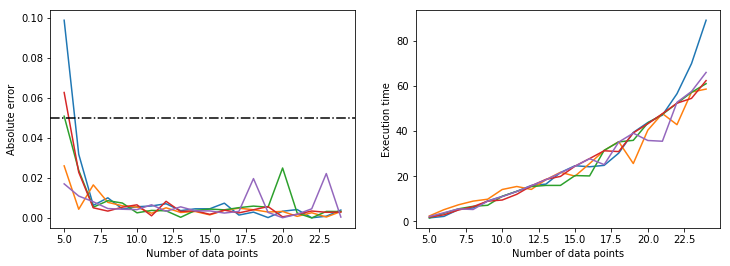

In [14]:
plt.show()

We notice that the absolute error is bounded at 0.01 for a short range of the number of data points. The irregularity can be fixed by doing multiple optimisations and taking the minimum from the results. We employ this trick in further notebooks.

The execution time shows a monotonic trend upong increasing the number of data points.